In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import numpy as np
import xarray as xr
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
import regional_library as ml

# Test run! See if we get a working model from the experiment class

In [4]:
reload(ml)

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95]
xextent = [-217 + 360, -210 + 360]
expt_name = "test-pathway"

pwd = "$KQ%QqFxjSSbE2"
usr = "abarnes"


daterange = ["2015-01-01 00:00:00", "2015-01-31 00:00:00"]

## Place where all your input files go
inputdir = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/reanalysis-small/"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables


### First make an experiment object
This keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

Sanity check: After running you a sensible hgrid and vgrind should appear in your input directory.

In [5]:
expt = ml.experiment(
    xextent,
    yextent,
    0.0333,  ## Resolution
    75,      ## #zlayers
    20,       ## dz ratio
    3000,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)

FRE TOOLS: Make hgrid 

 CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_hgrid/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid.nc'], returncode=0)
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/test-pathway//inputdir/test-pathway': File exists
ln: failed to create symbolic link '/scratch/v45/ab8992/mom6/regional_configs/test-pathway//rundir/test-pathway': File exists


## Next, handle the ocean forcing.

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

If you haven't used the script that pulls down the Glorys data, be sure to cut out your boundaries and name them like "north_segment_unprocessed", and your IC like "ic_segment_unprocessed"

In [ ]:
a = expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}},
    boundaries = ["south","north","west","east"]
    )

In [ ]:
expt.make_bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon","yh":"lat","elevation":"elevation"},
    )

## Things to handle:
* Forcing files that have negative longitudes. Should ensure that xextent always means the same thing
* Have all of my compiled fre tools together in the same folder

## Below is stuff copied from the old notebook that's not in pipeline. 
* Runoff
* Make mask
* copy default run directory

In [8]:
from regional_model_scripts import regrid_runoff
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc"

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    np.array(xextent) - np.array([180,180]),
    yextent)

## Modify the default input directory to make a (hopefully) runnable configuration out of the box

In [63]:
subprocess.run(f"cp default_rundir/* {rundir}",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

subprocess.run(f"cp vcoord.nc {inputdir}",shell=True)

ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/test-pathway//inputdir/test-pathway': File exists


CompletedProcess(args='cp vcoord.nc /scratch/v45/ab8992/mom6/regional_configs/test-pathway/', returncode=0)

# Testing access om2 input below

In [2]:
reload(ml)

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95]
xextent = [-217 + 360, -210 + 360]
expt_name = "om2-input"

pwd = "$KQ%QqFxjSSbE2"
usr = "abarnes"


daterange = ["1901-01-01 00:00:00", "1901-01-31 00:00:00"]

## Place where all your input files go
inputdir = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/rawboundaries"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables

expt = ml.experiment(
    xextent,
    yextent,
    0.0333,  ## Resolution
    75,      ## #zlayers
    20,       ## dz ratio
    3000,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)

FRE TOOLS: Make hgrid 

 CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_hgrid/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid.nc'], returncode=0)
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/om2-input//inputdir/om2-input': File exists
ln: failed to create symbolic link '/scratch/v45/ab8992/mom6/regional_configs/om2-input//rundir/om2-input': File exists


In [3]:
om2_input = xr.open_mfdataset("/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_daily*",decode_times = False)

In [13]:
xextent

[143, 150]

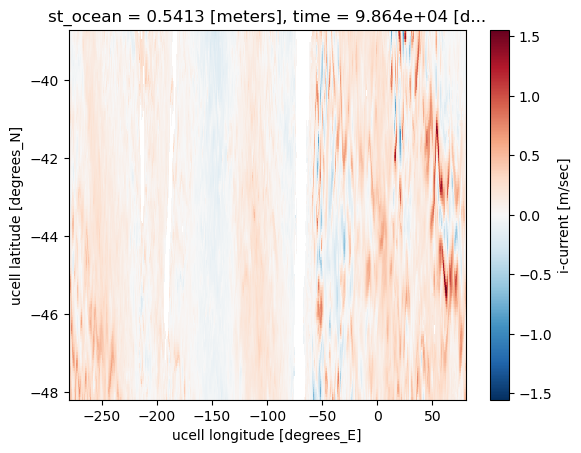

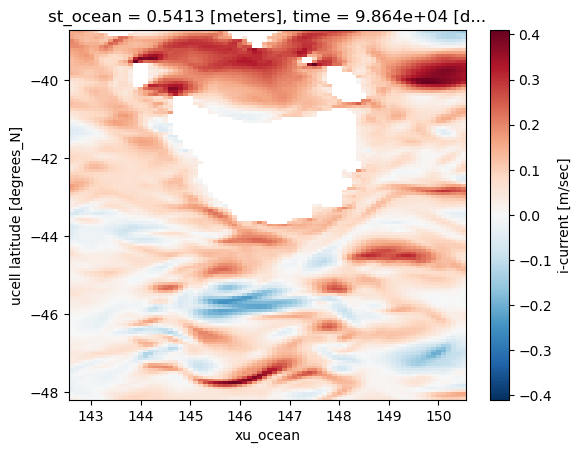

In [12]:
reload(ml)
import matplotlib.pyplot as plt

ic = om2_input[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = 0)
ic = ml.nicer_slicer(ic,[xextent[0] - 0.2,xextent[1] + 0.2],"xu_ocean")
ic = ml.nicer_slicer(ic,[xextent[0] - 0.2,xextent[1] + 0.2],"xt_ocean")
ic.to_netcdf(tmpdir + "/ic_unprocessed")

east = om2_input[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = 0)
east = ml.nicer_slicer(east,[xextent[0] - 0.2,xextent[1] + 0.2],"xu_ocean")
east = ml.nicer_slicer(east,[xextent[0] - 0.2,xextent[1] + 0.2],"xt_ocean")
east.to_netcdf(tmpdir + "/ic_unprocessed")


In [8]:
ic = om2_input[["u","v","salt","temp","eta_t"]].sel(
    xt_ocean = slice(xextent[0] - 0.2,xextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),    
    xu_ocean = slice(xextent[0] - 0.2,xextent[1] + 0.2),
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = 0)

ic["xu_ocean"] += 360

# .to_netcdf(tmpdir + "/ic_unprocessed")

# om2_input[["u","v","salt","temp","eta_t"]].sel(
#     xt_ocean = slice(xextent[1] - 0.2,xextent[1] + 0.2),
#     yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
# ).to_netcdf(tmpdir + "/east_unprocessed")

# om2_input[["u","v","salt","temp","eta_t"]].sel(
#     xt_ocean = slice(xextent[0] - 0.2,xextent[0] + 0.2),
#     yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
# ).to_netcdf(tmpdir + "/west_unprocessed")

# om2_input[["u","v","salt","temp","eta_t"]].sel(
#     xt_ocean = slice(xextent[0] - 0.2,xextent[1] + 0.2),
#     yt_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2)
# ).to_netcdf(tmpdir + "/north_unprocessed")

# om2_input[["u","v","salt","temp","eta_t"]].sel(
#     xt_ocean = slice(xextent[0] - 0.2,xextent[1] + 0.2),
#     yt_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2)
# ).to_netcdf(tmpdir + "/south_unprocessed")

TypeError: Values of an IndexVariable are immutable and can not be modified inplace

### Seam fixer

#1 Identify where the seam is in the dataset. If not between xextent[0] and xextent[1], do nothing.
#2 Identify how far seam 

In [130]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def nicer_slicer(data,xextent,x):
    
    return


xextent = [250,280]

hgrid = np.linspace(250,280,20)


data = xr.Dataset(
    {"t":(["x"],np.arange(360))},
    coords = {"x":np.linspace(-270,90,360)}
)

# data = xr.Dataset(
#     {"t":(["x"],np.arange(360))},
#     coords = {"x":np.linspace(-180,180,360)}
# )


seam = data.x[-1].values ## Seam is always positive definined this way

mp_target = np.mean(xextent) ## Midpoint of target domain
dx = xextent[1] - mp_target


## Find a corresponding value for the intended domain midpint in our data. Assuming here that data has equally spaced longitude values spanning 360deg
for i in range(-1,2,1):
    if (data.x[0] <= mp_target + 360 * i <= data.x[-1]):
        _mp_target = mp_target + 360 * i ## Shifted version of target midpoint. eg, could be -90 vs 270


        mp_data = data.x[data[x]shape[0]//2].values

        shift = (data[x]shape[0] * (_mp_target - mp_data)) // 360
        shift = int(shift)

        new_data = data.roll(x = -1 * shift,roll_coords=True)   ## Shifts data so that the midpoint of regional domain is in the middle of xarray for easy slicing

        new_x = new_data[x]values


        ## Take the 'seam' of the data, and either backfill or forward fill based on whether the data was shifted east or west
        if shift < 0:
            new_seam_index = shift

            new_x[0:new_seam_index] += 360

        if shift > 0:
            new_seam_index = shift

            new_x[new_seam_index:] -= 360


        

        new_data = new_data.assign_coords({"x":new_x})

        ## Choose the number of x points to take from the middle, including a buffer. Use this to index the new global dataset

        num_xpoints = int(data[x]shape[0]* (mp_target - xextent[0]))// 360 + 8 ## The extra 8 is a buffer region

        sliced_data = new_data.isel(x = slice(data[x]shape[0]//2 - num_xpoints,data[x]shape[0]//2 + num_xpoints))







## Now we have the right data, but the underlying grid may still be wrong. Need to check the start and end sign values and adjust accordingly

    
    



Asdfasdfa


In [13]:
a = expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time","yh":"yt_ocean","xh":"xt_ocean",
     "xq":"xu_ocean","yq":"yu_ocean",
     "zl":"st_ocean","eta":"eta_t","u":"u","v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'cfradial1', 'furuno', 'gamic', 'gini', 'iris', 'odim', 'pydap', 'radolan', 'rainbow', 'rasterio', 'wradlib-cfradial1', 'wradlib-cfradial2', 'wradlib-furuno', 'wradlib-gamic', 'wradlib-iris', 'wradlib-odim', 'wradlib-rainbow', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html